In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import torch 

This notebook is a guide through the library of the project "". :)

Météo-France, CNRS, CNRM, Centre d’Etudes de la Neige \
Léo Catteau, Spring 2025

### Contents:
* [The Dataset ](#first-bullet)
* [Baseline](#second-bullet)
* [Robustness to masking](#third-bullet)
* [Sequence masking](#fourth-bullet)
* [Machine learning paradigm](#fifth-bullet)
* [Deep MLP](#sixth-bullet)

### The Dataset <a class="anchor" id="first-bullet"></a>

In [3]:
dataset = xr.load_dataset('datasets/bdclim_safran_2022-2024.nc').transpose()
dataset = dataset.assign_coords(station_count=("num_poste", np.arange(len(dataset.num_poste))))
dataset

<xarray.Dataset> Size: 185MB
Dimensions:              (time: 10000, num_poste: 2303)
Coordinates: (12/19)
  * time                 (time) datetime64[ns] 80kB 2022-11-10T09:00:00 ... 2...
  * num_poste            (num_poste) int64 18kB 1014002 1027003 ... 205026002
    Station_Name         (num_poste) <U30 276kB 'ARBENT' 'BALAN_AERO' ... 'FAHY'
    ZS                   (num_poste) int64 18kB 534 196 350 420 ... 485 411 596
    lat                  (num_poste) float64 18kB 46.28 45.83 ... 46.25 47.42
    lon                  (num_poste) float64 18kB 5.669 5.107 ... 6.128 6.941
    ...                   ...
    slope_30m            (num_poste) float32 9kB 2.644 0.928 ... 2.388 0.464
    slope_500m           (num_poste) float32 9kB 0.3522 0.6428 ... 0.4696 0.3549
    aspect_500m          (num_poste) float32 9kB 251.6 197.7 ... 11.98 205.6
    TPI_1000m            (num_poste) float32 9kB -30.38 -2.75 ... -12.25 11.62
    type_temps           (time) int64 80kB 8 8 8 4 4 4 4 4 4 ... 2 2 2 2 2 2 2 2
    station_count        (num_poste) int64 18kB 0 1 2 3 ... 2299 2300 2301 2302
Data variables:
    t                    (num_poste, time) float64 184MB 10.3 10.8 ... 4.2 4.2

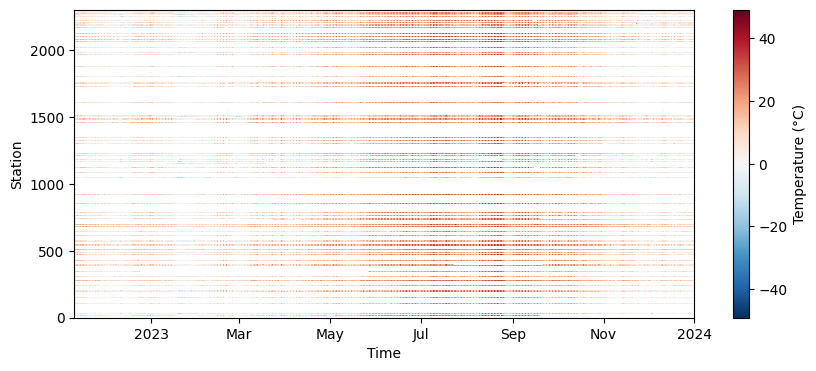

In [4]:
plt.figure(figsize=(10, 4))
dataset['t'].plot(x='time', y='station_count', cbar_kwargs={'label': "Temperature (°C)"})
plt.xlabel("Time")
plt.ylabel("Station")
plt.show()

### Baseline <a class="anchor" id="second-bullet"></a>

In [5]:
from data_provider.data_factory import data_provider
from models.baseline import mean_fill, svd, linear

from types import SimpleNamespace
from sklearn.metrics import mean_squared_error

In [6]:
args = SimpleNamespace()
args.data = 'bdclim_clean_mask'
args.root_path = 'datasets/'
args.data_path = 'bdclim_safran_2022-2024.nc'
args.scale = False
args.batch_size = 1
args.mask_proba = 0.6

optimal rank: 11


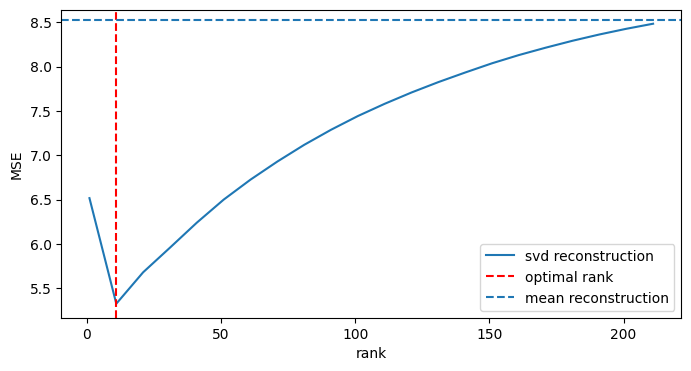

In [7]:
# training equivalent
train_dataset, train_dataloader = data_provider(args, flag='train')
X_train, y_train = train_dataset[:]

mean_model = mean_fill()

svd_model = svd()
svd_model.train(X_train, y_train, verbose=True)

linear_model = linear()
linear_model.train(X_train, y_train)

In [8]:
test_dataset, test_dataloader = data_provider(args, flag='test')
X_test, y_test = test_dataset[:]

y_pred_mean = mean_model(X_test)
MSE_mean = mean_squared_error(y_pred_mean, y_test)

y_pred_svd = svd_model.predict(X_test)
MSE_svd = mean_squared_error(y_pred_svd, y_test)

y_pred_linear = linear_model.predict(X_test)
MSE_linear = mean_squared_error(y_pred_linear, y_test)

print(f'MSE Mean: {MSE_mean}, MSE SVD: {MSE_svd}, MSE Linear: {MSE_linear}')

MSE Mean: 14.912496566772461, MSE SVD: 5.478763580322266, MSE Linear: 1.9318662881851196


### Robustness to masking <a class="anchor" id="third-bullet"></a>

In [9]:
from experiments.experiments import masking_robustness

args.data = 'bdclim_clean_mask'
args.root_path = 'datasets/'
args.data_path = 'bdclim_safran_2022-2024.nc'
args.scale = False
args.batch_size = 1

probas, MSE_mean, MSE_svd, MSE_linear = masking_robustness(args, physics=False)

100%|██████████| 40/40 [01:00<00:00,  1.50s/it]


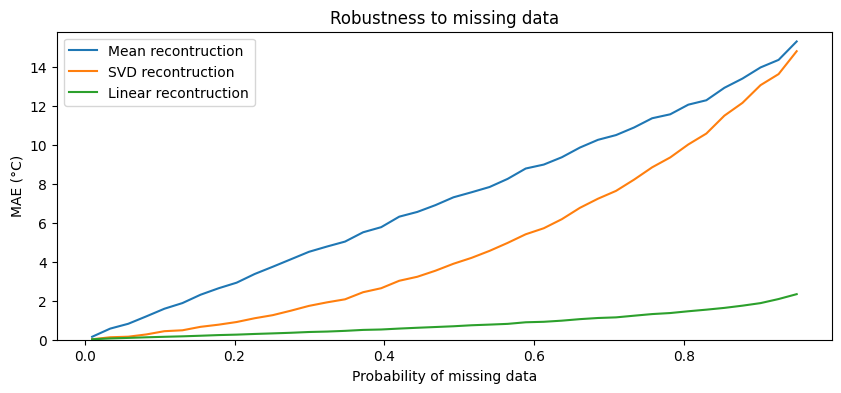

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(probas, MSE_mean['mean'], label='Mean recontruction')
plt.plot(probas, MSE_svd['mean'], label='SVD recontruction')
plt.plot(probas, MSE_linear['mean'], label='Linear recontruction')
plt.ylim(0, max(MSE_mean['mean'])+.5)
plt.xlabel("Probability of missing data")
plt.ylabel("MAE (°C)")
plt.legend()
plt.title("Robustness to missing data")
plt.show()

## Sequence masking  <a class="anchor" id="fourth-bullet"></a>

In [11]:
args = SimpleNamespace()
args.data = 'bdclim_clean_sequence_mask'
args.root_path = 'datasets/'
args.data_path = 'bdclim_safran_2022-2024.nc'
args.scale = False
args.batch_size = 1
args.mask_proba = 0.5
args.mask_len = 24*10

train_dataset, train_dataloader = data_provider(args, flag='test')
X_train, y_train = train_dataset[:]

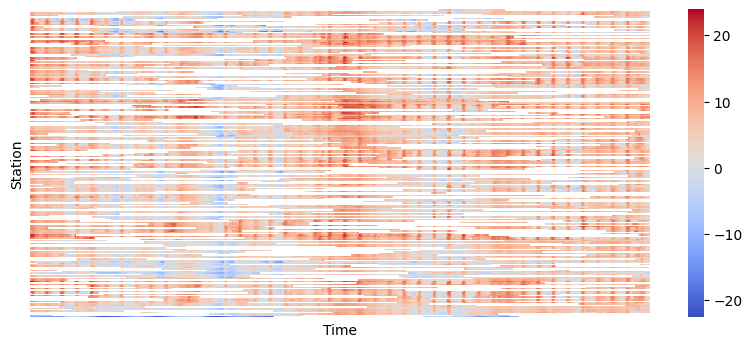

In [12]:
plt.figure(figsize=(10, 4))
sns.heatmap(X_train.T, xticklabels=False, yticklabels=False, cmap="coolwarm")
plt.xlabel("Time")
plt.ylabel("Station")
plt.show()

In [13]:
mean_model = mean_fill(columnwise=True)

svd_model = svd()
svd_model.train(X_train, y_train)

linear_model = linear()
linear_model.train(X_train, y_train)

In [14]:
test_dataset, test_dataloader = data_provider(args, flag='test')
X_test, y_test = test_dataset[:]

y_pred_mean = mean_model(X_test)
MSE_mean = mean_squared_error(y_pred_mean, y_test)

y_pred_svd = svd_model.predict(X_test)
MSE_svd = mean_squared_error(y_pred_svd, y_test)

y_pred_linear = linear_model.predict(X_test)
MSE_linear = mean_squared_error(y_pred_linear, y_test)

print(f'MSE Mean: {MSE_mean}, MSE SVD: {MSE_svd}, MSE Linear: {MSE_linear}')

MSE Mean: 5.885657787322998, MSE SVD: 4.116475582122803, MSE Linear: 3.422929525375366


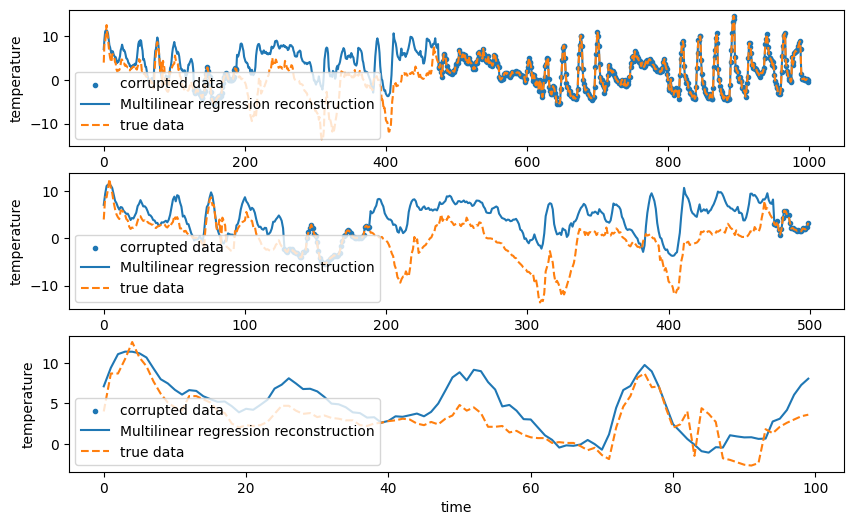

In [15]:
station = np.random.choice(np.arange(0, X_test.shape[1]))

fig, ax = plt.subplots(3, 1, figsize=(10, 6))
ax[0].scatter(np.arange(0, X_test.shape[0]), X_test[:,station], label='corrupted data', marker='.')
ax[0].plot(y_pred_linear[:,station], label='Multilinear regression reconstruction')
ax[0].plot(y_test[:,station], label='true data', linestyle='--')
ax[0].set_xlabel('time')
ax[0].set_ylabel('temperature')
ax[0].legend(loc='lower left')
ax[1].scatter(np.arange(0, X_test.shape[0])[:500], X_test[:500,station], label='corrupted data', marker='.')
ax[1].plot(y_pred_linear[:500,station], label='Multilinear regression reconstruction')
ax[1].plot(y_test[:500,station], label='true data', linestyle='--')
ax[1].set_xlabel('time')
ax[1].set_ylabel('temperature')
ax[1].legend(loc='lower left')
ax[2].scatter(np.arange(0, X_test.shape[0])[:100], X_test[:100,station], label='corrupted data', marker='.')
ax[2].plot(y_pred_linear[:100,station], label='Multilinear regression reconstruction')
ax[2].plot(y_test[:100,station], label='true data', linestyle='--')
ax[2].set_xlabel('time')
ax[2].set_ylabel('temperature')
ax[2].legend(loc='lower left')

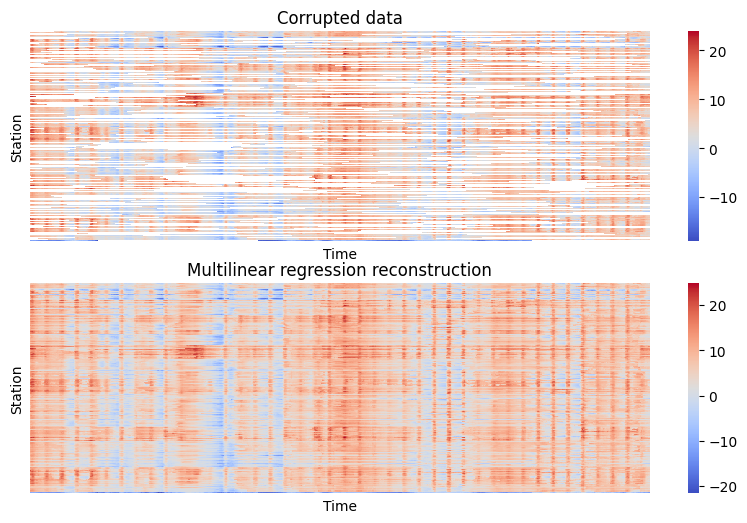

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
sns.heatmap(X_test.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Corrupted data")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Station")
sns.heatmap(y_pred_linear.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[1])
ax[1].set_title("Multilinear regression reconstruction")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Station")
plt.show()

## Machine learning paradigm <a class="anchor" id="fifth-bullet"></a>

In [17]:
from data_provider.data_factory import data_provider
from models.baseline import linear_MLP
from experiments.basics import train

from types import SimpleNamespace
from sklearn.metrics import mean_squared_error

In [18]:
args = SimpleNamespace()
args.data = 'bdclim_clean_sequence_mask'
args.root_path = 'datasets/'
args.data_path = 'bdclim_safran_2022-2024.nc'
args.scale = False
args.batch_size = 100
args.mask_proba = 0.7
args.mask_len = 24*30

train_dataset, train_dataloader = data_provider(args, flag='train')
test_dataset, test_dataloader = data_provider(args, flag='test')
X_train, y_train = train_dataset[:]

In [19]:
linear_MLP_model = linear_MLP(seq_dim=X_train.shape[1])
train_loss, test_loss = train(model=linear_MLP_model, 
                              train_dataloader=train_dataloader, 
                              test_dataloader=test_dataloader, 
                              lr=0.001, epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


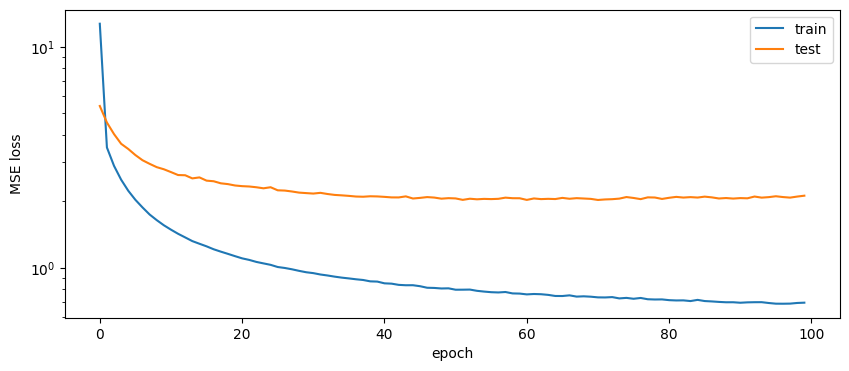

In [20]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.show()

In [21]:
test_dataset, test_dataloader = data_provider(args, flag='test')
X_test, y_test = test_dataset[:]

y_pred_linear = linear_MLP_model(X_test).detach().numpy()
MSE_linear = mean_squared_error(y_pred_linear, y_test)

print(f'MSE Linear MLP: {MSE_linear}')

MSE Linear MLP: 2.6178557872772217


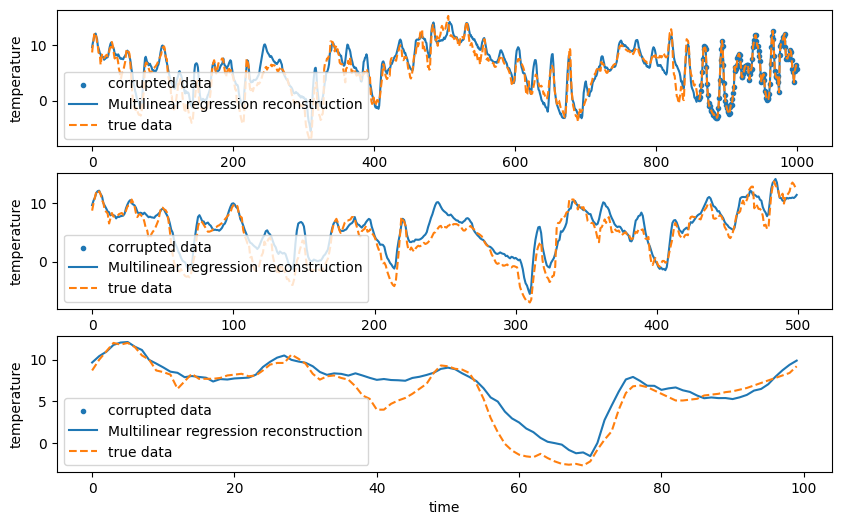

In [22]:
station = np.random.choice(np.arange(0, X_test.shape[1]))

fig, ax = plt.subplots(3, 1, figsize=(10, 6))
ax[0].scatter(np.arange(0, X_test.shape[0]), X_test[:,station], label='corrupted data', marker='.')
ax[0].plot(y_pred_linear[:,station], label='Multilinear regression reconstruction')
ax[0].plot(y_test[:,station], label='true data', linestyle='--')
ax[0].set_xlabel('time')
ax[0].set_ylabel('temperature')
ax[0].legend(loc='lower left')
ax[1].scatter(np.arange(0, X_test.shape[0])[:500], X_test[:500,station], label='corrupted data', marker='.')
ax[1].plot(y_pred_linear[:500,station], label='Multilinear regression reconstruction')
ax[1].plot(y_test[:500,station], label='true data', linestyle='--')
ax[1].set_xlabel('time')
ax[1].set_ylabel('temperature')
ax[1].legend(loc='lower left')
ax[2].scatter(np.arange(0, X_test.shape[0])[:100], X_test[:100,station], label='corrupted data', marker='.')
ax[2].plot(y_pred_linear[:100,station], label='Multilinear regression reconstruction')
ax[2].plot(y_test[:100,station], label='true data', linestyle='--')
ax[2].set_xlabel('time')
ax[2].set_ylabel('temperature')
ax[2].legend(loc='lower left')

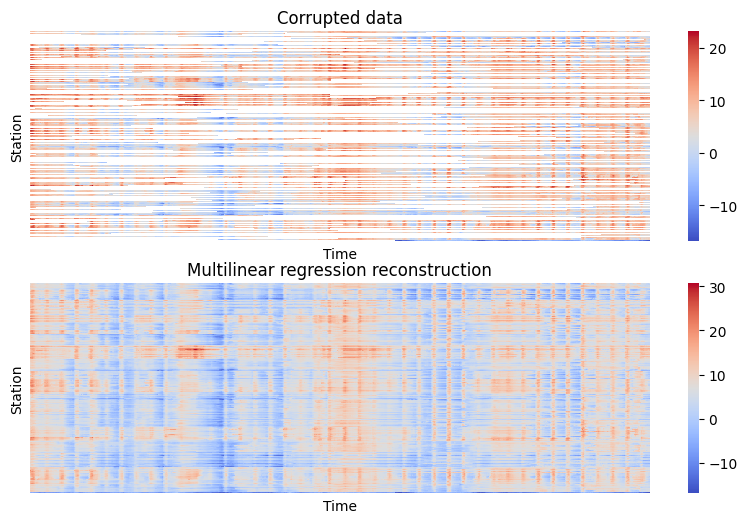

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
sns.heatmap(X_test.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Corrupted data")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Station")
sns.heatmap(y_pred_linear.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[1])
ax[1].set_title("Multilinear regression reconstruction")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Station")
plt.show()

## Deep MLP <a class="anchor" id="sixth-bullet"></a>

In [24]:
from data_provider.data_factory import data_provider
from models.baseline import linear_MLP
from models.MLP import MLP
from experiments.basics import train

from types import SimpleNamespace
from sklearn.metrics import mean_squared_error

In [25]:
args = SimpleNamespace()
args.data = 'bdclim_clean_sequence_mask'
args.root_path = 'datasets/'
args.data_path = 'bdclim_safran_2022-2024.nc'
args.scale = False
args.batch_size = 100
args.mask_proba = 0.7
args.mask_len = 24*30*1

train_dataset, train_dataloader = data_provider(args, flag='train')
test_dataset, test_dataloader = data_provider(args, flag='test')
X_train, y_train = train_dataset[:]

In [26]:
MLP_model = MLP(seq_dim=X_train.shape[1], hidden_dim=4*X_train.shape[1])
train_loss, test_loss = train(model=MLP_model, 
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader, 
                              lr=0.00001, epochs=100)

100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


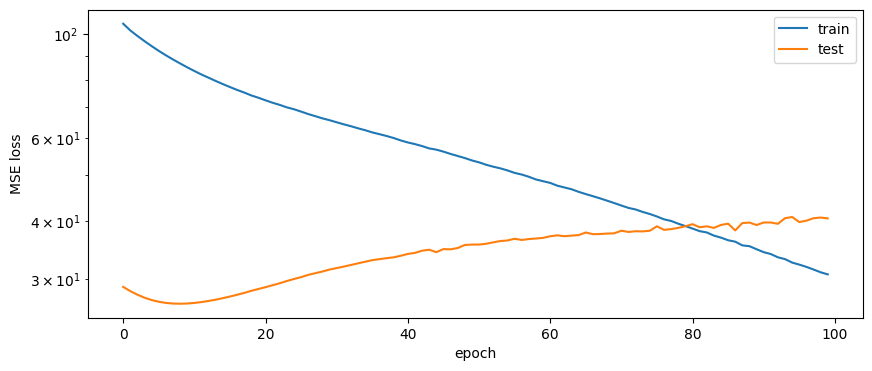

In [27]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.show()

In [28]:
test_dataset, test_dataloader = data_provider(args, flag='test')
X_test, y_test = test_dataset[:]

y_pred_MLP = MLP_model(X_test).detach().numpy()
MSE_MLP = mean_squared_error(y_pred_MLP, y_test)

print(f'MSE Linear MLP: {MSE_MLP}')

MSE Linear MLP: 32.446861267089844


100%|██████████| 40/40 [02:48<00:00,  4.20s/it]


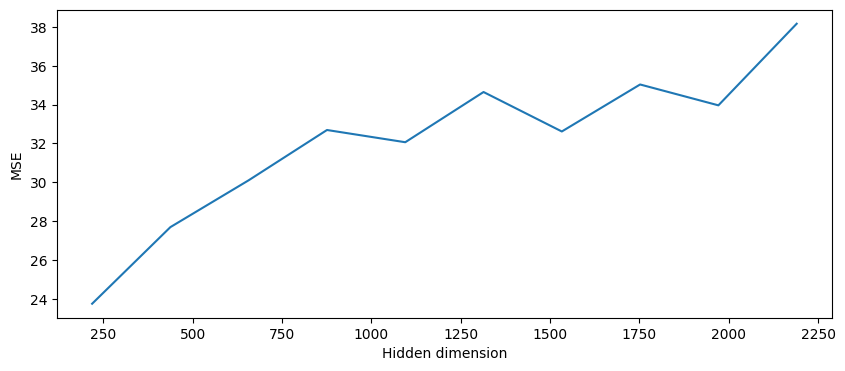

In [29]:
hidden_dims = np.linspace(X_train.shape[1], int(10*X_train.shape[1]), 10, dtype=int)
MSEs = []
for hidden_dim in hidden_dims:
    MLP_model = MLP(seq_dim=X_train.shape[1], hidden_dim=hidden_dim)
    train_loss, test_loss = train(model=MLP_model, 
                                  train_dataloader=train_dataloader, 
                                  test_dataloader=test_dataloader, 
                                  lr=0.0005, epochs=40)
    MSE_MLP = min(test_loss)
    MSEs.append(MSE_MLP)

plt.figure(figsize=(10, 4))
plt.plot(hidden_dims, MSEs)
plt.xlabel("Hidden dimension")
plt.ylabel("MSE")
plt.show()

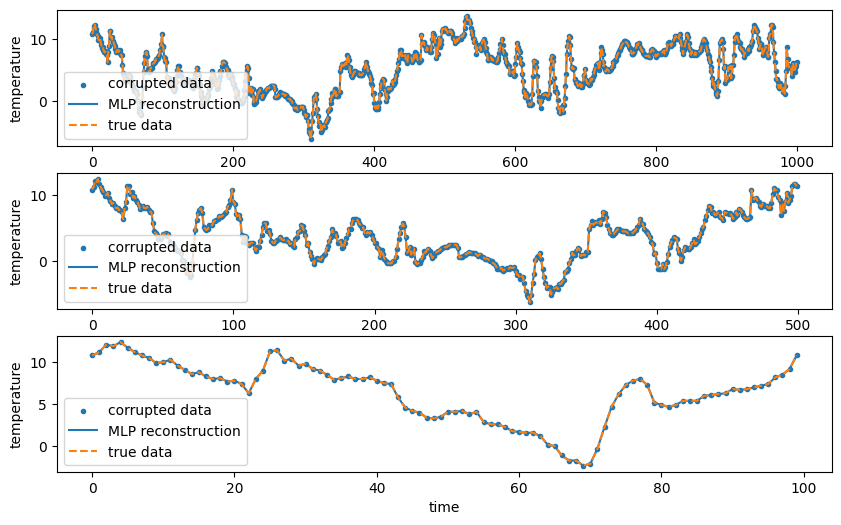

In [30]:
station = np.random.choice(np.arange(0, X_test.shape[1]))

fig, ax = plt.subplots(3, 1, figsize=(10, 6))
ax[0].scatter(np.arange(0, X_test.shape[0]), X_test[:,station], label='corrupted data', marker='.')
ax[0].plot(y_pred_MLP[:,station], label='MLP reconstruction')
ax[0].plot(y_test[:,station], label='true data', linestyle='--')
ax[0].set_xlabel('time')
ax[0].set_ylabel('temperature')
ax[0].legend(loc='lower left')
ax[1].scatter(np.arange(0, X_test.shape[0])[:500], X_test[:500,station], label='corrupted data', marker='.')
ax[1].plot(y_pred_MLP[:500,station], label='MLP reconstruction')
ax[1].plot(y_test[:500,station], label='true data', linestyle='--')
ax[1].set_xlabel('time')
ax[1].set_ylabel('temperature')
ax[1].legend(loc='lower left')
ax[2].scatter(np.arange(0, X_test.shape[0])[:100], X_test[:100,station], label='corrupted data', marker='.')
ax[2].plot(y_pred_MLP[:100,station], label='MLP reconstruction')
ax[2].plot(y_test[:100,station], label='true data', linestyle='--')
ax[2].set_xlabel('time')
ax[2].set_ylabel('temperature')
ax[2].legend(loc='lower left')

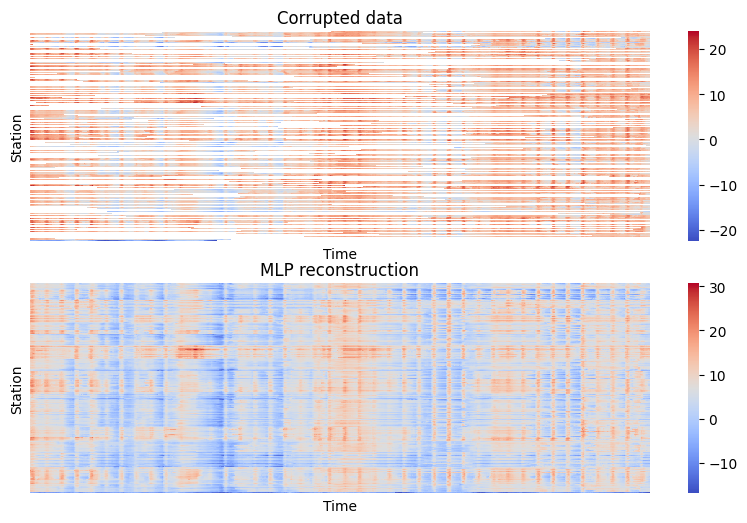

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
sns.heatmap(X_test.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Corrupted data")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Station")
sns.heatmap(y_pred_linear.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[1])
ax[1].set_title("MLP reconstruction")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Station")
plt.show()